In [3]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 389.4 kB/s eta 0:00:00a 0:00:01


In [47]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense,
    Conv2D,
    MaxPooling2D,
    Flatten,
    Dropout,
    BatchNormalization,
    Input,
    Add,
)
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
import keras_tuner as kt

import numpy as np
import matplotlib.pyplot as plt

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.19.0


In [49]:
# --- 1. Load and Prepare the CIFAR-10 Dataset ---
print("\n--- Step 1: Loading and Preprocessing Data ---")

# CIFAR-10 class names for later use
CLASS_NAMES = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]
NUM_CLASSES = len(CLASS_NAMES)

# Load the data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# a. Split the training data into training and validation sets (90% train, 10% validation)
split_index = int(len(x_train) * 0.9)
x_train_split, x_val = x_train[:split_index], x_train[split_index:]
y_train_split, y_val = y_train[:split_index], y_train[split_index:]

print(f"Original training images: {len(x_train)}")
print(f"Split training images: {len(x_train_split)}")
print(f"Validation images: {len(x_val)}")
print(f"Test images: {len(x_test)}")

# b. Normalize pixel values to be between 0 and 1
x_train_split = x_train_split.astype("float32") / 255.0
x_val = x_val.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# c. Convert labels to one-hot encoding
y_train_split = keras.utils.to_categorical(y_train_split, NUM_CLASSES)
y_val = keras.utils.to_categorical(y_val, NUM_CLASSES)
y_test = keras.utils.to_categorical(y_test, NUM_CLASSES)

# d. Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1,
)
datagen.fit(x_train_split)


--- Step 1: Loading and Preprocessing Data ---
Original training images: 50000
Split training images: 45000
Validation images: 5000
Test images: 10000


In [51]:
# --- 2. Design the CNN Architecture ---
print("\n--- Step 2: Designing the CNN Model ---")

# a. Implement a Residual Block
def residual_block(x, filters, kernel_size=3, stride=1, l2_reg=0.001):
    """
    A residual block with two convolutional layers.
    The shortcut connection is used to match dimensions if stride is not 1.
    """
    shortcut = x
    
    # First convolutional layer
    y = Conv2D(
        filters,
        kernel_size=kernel_size,
        strides=stride,
        padding="same",
        kernel_initializer="he_normal",
        kernel_regularizer=l2(l2_reg),
    )(x)
    y = BatchNormalization()(y)
    y = layers.ReLU()(y)

    # Second convolutional layer
    y = Conv2D(
        filters,
        kernel_size=kernel_size,
        padding="same",
        kernel_initializer="he_normal",
        kernel_regularizer=l2(l2_reg),
    )(y)
    y = BatchNormalization()(y)

    # If the stride changes the dimension, we need to adjust the shortcut
    if stride != 1 or x.shape[-1] != filters:
        shortcut = Conv2D(
            filters,
            kernel_size=1,
            strides=stride,
            padding="same",
            kernel_initializer="he_normal",
            kernel_regularizer=l2(l2_reg),
        )(shortcut)
        shortcut = BatchNormalization()(shortcut)
    
    # Add the shortcut to the output of the conv layers
    out = Add()([y, shortcut])
    out = layers.ReLU()(out)
    return out

# b. Build the full model using the Keras Functional API
def build_model(hp):
    """
    Builds the complete CNN model. Can be used standalone or with Keras Tuner.
    """
    # Hyperparameters for Keras Tuner
    l2_reg = hp.Choice('l2_reg', values=[1e-3, 1e-4])
    dropout_rate = hp.Float('dropout_rate', min_value=0.25, max_value=0.5, step=0.05)
    learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    input_shape = (32, 32, 3)
    inputs = Input(shape=input_shape)

    # Initial Convolutional Layer
    x = Conv2D(
        32,
        (3, 3),
        padding="same",
        kernel_initializer="he_normal",
        kernel_regularizer=l2(l2_reg),
    )(inputs)
    x = BatchNormalization()(x)
    x = layers.ReLU()(x)

    # --- Residual Blocks ---
    x = residual_block(x, filters=64, l2_reg=l2_reg)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(dropout_rate)(x)

    x = residual_block(x, filters=128, l2_reg=l2_reg)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(dropout_rate)(x)
    
    x = residual_block(x, filters=256, l2_reg=l2_reg)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(dropout_rate)(x)

    # --- Classifier Head ---
    x = Flatten()(x)
    x = Dense(
        512,
        activation="relu",
        kernel_initializer="he_normal",
        kernel_regularizer=l2(l2_reg),
    )(x)
    x = Dropout(0.5)(x)
    outputs = Dense(NUM_CLASSES, activation="softmax")(x)

    model = Model(inputs=inputs, outputs=outputs)

    # c. Choose optimizer and loss function
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    
    # d. Choose validation metrics
    model.compile(
        optimizer=optimizer,
        loss="categorical_crossentropy",
        metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall()],
    )
    return model


--- Step 2: Designing the CNN Model ---


In [57]:
# --- 4b. (Bonus) Use Keras Tuner to Find Best Hyperparameters ---
print("\n--- Step 4b: Hyperparameter Tuning with Keras Tuner ---")

# MODIFICATION: Changed from Hyperband to RandomSearch to limit trials.
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=3,  # This will run exactly 3 different hyperparameter combinations.
    executions_per_trial=1, # How many models to build and fit for each trial
    directory='keras_tuner_dir',
    project_name='cifar10_tuning_random_search' # Use a new project name
)


# Early stopping for the tuner search
tuner_stop_early = EarlyStopping(monitor='val_loss', patience=5)

# Start the search
print("Starting hyperparameter search...")
tuner.search(
    x_train_split, y_train_split,
    epochs=10,
    validation_data=(x_val, y_val),
    callbacks=[tuner_stop_early]
)

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
Hyperparameter search is complete. The optimal values are:
- L2 Regularization: {best_hps.get('l2_reg')}
- Dropout Rate: {best_hps.get('dropout_rate')}
- Learning Rate: {best_hps.get('learning_rate')}
""")

Trial 3 Complete [00h 40m 17s]
val_accuracy: 0.5013999938964844

Best val_accuracy So Far: 0.7716000080108643
Total elapsed time: 02h 02m 37s

Hyperparameter search is complete. The optimal values are:
- L2 Regularization: 0.0001
- Dropout Rate: 0.3
- Learning Rate: 0.001




--- Step 3: Training the Final Model ---


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_40 (Conv2D)  │ (None, 32, 32,    │        896 │ input_layer_4[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        128 │ conv2d_40[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_28 (ReLU)     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_41 (Conv2D)  │ (None, 32, 32,    │     18,496 │ re_lu_28[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_41[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_29 (ReLU)     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_42 (Conv2D)  │ (None, 32, 32,    │     36,928 │ re_lu_29[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_43 (Conv2D)  │ (None, 32, 32,    │      2,112 │ re_lu_28[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_42[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_43[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_12 (Add)        │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_30 (ReLU)     │ (None, 32, 32,    │          0 │ add_12[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_12    │ (None, 16, 16,    │          0 │ re_lu_30[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_16          │ (None, 16, 16,    │          0 │ max_pooling2d_12… │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_44 (Conv2D)  │ (None, 16, 16,    │     73,856 │ dropout_16[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        512 │ conv2d_44[0][0] 

 Total params: 3,314,762 (12.64 MB)

 Trainable params: 3,312,010 (12.63 MB)

 Non-trainable params: 2,752 (10.75 KB)

Epoch 1/5
351/351 ━━━━━━━━━━━━━━━━━━━━ 236s 666ms/step - accuracy: 0.1930 - loss: 3.4153 - precision_6: 0.2737 - recall_6: 0.0291 - val_accuracy: 0.2794 - val_loss: 2.4088 - val_precision_6: 0.6471 - val_recall_6: 0.0044 - learning_rate: 0.0010
Epoch 2/5
  1/351 ━━━━━━━━━━━━━━━━━━━━ 3:49 656ms/step - accuracy: 0.2344 - loss: 2.3328 - precision_6: 0.2500 - recall_6: 0.0391

/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


351/351 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.2344 - loss: 2.3328 - precision_6: 0.2500 - recall_6: 0.0391 - val_accuracy: 0.2708 - val_loss: 2.4204 - val_precision_6: 0.5405 - val_recall_6: 0.0040 - learning_rate: 0.0010
Epoch 3/5
351/351 ━━━━━━━━━━━━━━━━━━━━ 231s 659ms/step - accuracy: 0.3121 - loss: 2.1323 - precision_6: 0.5820 - recall_6: 0.0795 - val_accuracy: 0.3768 - val_loss: 2.0450 - val_precision_6: 0.6722 - val_recall_6: 0.1062 - learning_rate: 0.0010
Epoch 4/5
351/351 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.4141 - loss: 2.0067 - precision_6: 0.7200 - recall_6: 0.1406 - val_accuracy: 0.3836 - val_loss: 2.0036 - val_precision_6: 0.6628 - val_recall_6: 0.1148 - learning_rate: 0.0010
Epoch 5/5
351/351 ━━━━━━━━━━━━━━━━━━━━ 223s 636ms/step - accuracy: 0.3618 - loss: 1.9644 - precision_6: 0.6106 - recall_6: 0.1327 - val_accuracy: 0.4026 - val_loss: 1.9235 - val_precision_6: 0.5526 - val_recall_6: 0.2404 - learning_rate: 0.0010

--- Step 4: Evaluating the Model --

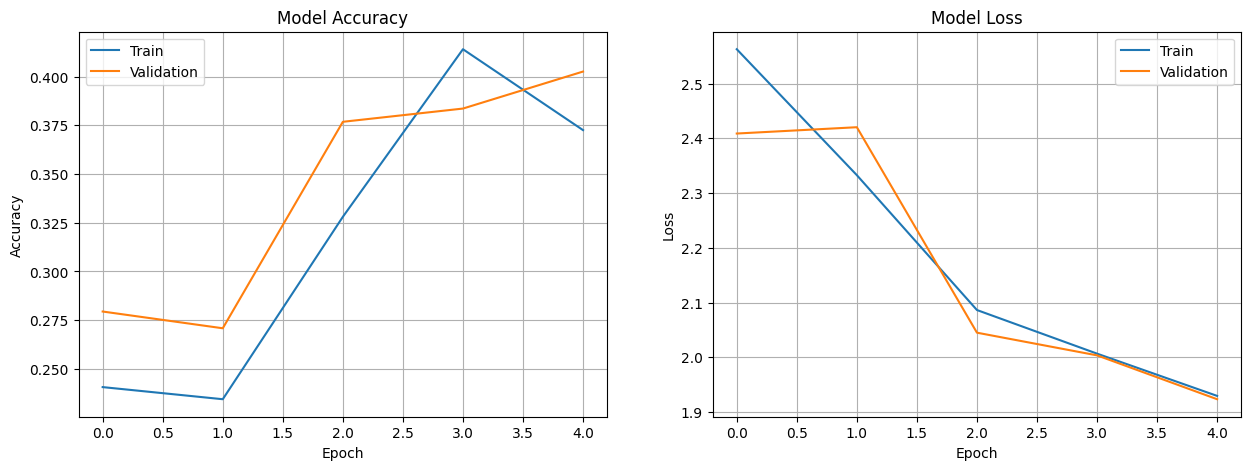

In [65]:
# --- 3. Train the Model with Best Hyperparameters ---
print("\n--- Step 3: Training the Final Model ---")

# Build the model with the best hyperparameters
final_model = tuner.hypermodel.build(best_hps)
final_model.summary()

# a. Set batch size and epochs
BATCH_SIZE = 128
EPOCHS = 5 # A higher number, but EarlyStopping will find the best point

# b. Define callbacks
# Learning rate schedule: decrease LR over time
def lr_scheduler(epoch, lr):
    if epoch > 0 and epoch % 15 == 0:
        return lr * 0.5
    return lr

lr_callback = LearningRateScheduler(lr_scheduler)

# Early stopping to prevent overfitting
early_stop_callback = EarlyStopping(
    monitor="val_loss", patience=10, restore_best_weights=True
)

# c. Train the model using the data generator
history = final_model.fit(
    datagen.flow(x_train_split, y_train_split, batch_size=BATCH_SIZE),
    steps_per_epoch=len(x_train_split) // BATCH_SIZE,
    epochs=5,
    validation_data=(x_val, y_val),
    callbacks=[early_stop_callback, lr_callback],
    verbose=1,
)

# --- 4. Evaluate and Plot Learning Curves ---
print("\n--- Step 4: Evaluating the Model ---")

# a. Evaluate on the test set
test_loss, test_acc, test_precision, test_recall = final_model.evaluate(x_test, y_test)
print(f"\nTest Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")

# b. Plot learning curves
def plot_learning_curves(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot training & validation accuracy values
    ax1.plot(history.history["accuracy"])
    ax1.plot(history.history["val_accuracy"])
    ax1.set_title("Model Accuracy")
    ax1.set_ylabel("Accuracy")
    ax1.set_xlabel("Epoch")
    ax1.legend(["Train", "Validation"], loc="upper left")
    ax1.grid(True)

    # Plot training & validation loss values
    ax2.plot(history.history["loss"])
    ax2.plot(history.history["val_loss"])
    ax2.set_title("Model Loss")
    ax2.set_ylabel("Loss")
    ax2.set_xlabel("Epoch")
    ax2.legend(["Train", "Validation"], loc="upper right")
    ax2.grid(True)

    plt.show()

plot_learning_curves(history)

In [67]:
# --- 5. Save the Model ---
print("\n--- Step 5: Saving the Final Model ---")
MODEL_FILENAME = "cifar10_resnet_model.h5"
final_model.save(MODEL_FILENAME)
print(f"Model saved successfully as {MODEL_FILENAME}")


--- Step 5: Saving the Final Model ---
Model saved successfully as cifar10_resnet_model.h5


In [75]:
pip install opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 1.5 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import cv2
import numpy as np
import tensorflow as tf

# --- Configuration ---
MODEL_FILENAME = "cifar10_resnet_model.h5"
# The model expects 32x32 pixel images.
IMG_WIDTH, IMG_HEIGHT = 32, 32 

# Define the CIFAR-10 class names in the correct order
CLASS_NAMES = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
]

# --- Load the Trained Model ---
try:
    print("Loading trained model...")
    # By default, Keras loads custom objects like the Add layer for residual blocks.
    # No custom_objects dict is needed for this architecture.
    model = tf.keras.models.load_model(MODEL_FILENAME)
    print("Model loaded successfully.")
    model.summary() # Print model summary to confirm it's loaded
except Exception as e:
    print(f"Error loading model: {e}")
    print(f"Please make sure the model file '{MODEL_FILENAME}' is in the same directory as this script.")
    exit()

# --- Initialize Webcam ---
cap = cv2.VideoCapture(0) # 0 is the default webcam
if not cap.isOpened():
    print("Error: Could not open webcam.")
    exit()

print("\nWebcam initialized. Starting real-time classification...")
print("Press 'q' to quit.")

while True:
    # Capture frame-by-frame
    ret, frame = cap.read()
    if not ret:
        print("Failed to grab frame.")
        break
        
    # Flip the frame horizontally for a more intuitive mirror-like view
    frame = cv2.flip(frame, 1)

    # --- Bounding Box for Classification ---
    # Define a region of interest (ROI) in the center of the frame
    frame_height, frame_width, _ = frame.shape
    roi_size = 300 # Size of the square bounding box
    
    # Calculate top-left corner of the ROI to center it
    x1 = (frame_width - roi_size) // 2
    y1 = (frame_height - roi_size) // 2
    x2 = x1 + roi_size
    y2 = y1 + roi_size

    # Extract the ROI from the frame
    roi = frame[y1:y2, x1:x2]

    # --- Preprocess the ROI for the Model ---
    # 1. Resize the ROI to the size the model expects (32x32)
    img_resized = cv2.resize(roi, (IMG_WIDTH, IMG_HEIGHT))
    
    # 2. Convert to float and normalize pixel values to [0, 1]
    img_normalized = img_resized.astype("float32") / 255.0
    
    # 3. Expand dimensions to create a batch of 1
    # Model expects input shape: (batch_size, height, width, channels)
    img_batch = np.expand_dims(img_normalized, axis=0)

    # --- Make a Prediction ---
    prediction = model.predict(img_batch, verbose=0) # Set verbose to 0 for cleaner output
    
    # Get the predicted class index and confidence
    predicted_class_index = np.argmax(prediction[0])
    confidence = np.max(prediction[0])
    
    # Get the corresponding class name
    predicted_class_name = CLASS_NAMES[predicted_class_index]
    
    # --- Display Results on the Frame ---
    # Draw the bounding box on the original frame
    cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2) # Green box

    # Create the text to display
    label_text = f"{predicted_class_name.upper()}: {confidence:.2%}"
    
    # Put the text above the bounding box
    cv2.putText(
        frame,
        label_text,
        (x1, y1 - 10), # Position of the text
        cv2.FONT_HERSHEY_SIMPLEX,
        0.7, # Font scale
        (0, 255, 0), # Font color (green)
        2 # Font thickness
    )

    # Display the resulting frame
    cv2.imshow('CIFAR-10 Real-time Classifier', frame)

    # Exit loop if 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# --- Cleanup ---
print("Closing application...")
cap.release()
cv2.destroyAllWindows()

Loading trained model...
Model loaded successfully.


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_40 (Conv2D)  │ (None, 32, 32,    │        896 │ input_layer_4[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        128 │ conv2d_40[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_28 (ReLU)     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_41 (Conv2D)  │ (None, 32, 32,    │     18,496 │ re_lu_28[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_41[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_29 (ReLU)     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_42 (Conv2D)  │ (None, 32, 32,    │     36,928 │ re_lu_29[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_43 (Conv2D)  │ (None, 32, 32,    │      2,112 │ re_lu_28[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_42[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_43[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_12 (Add)        │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_30 (ReLU)     │ (None, 32, 32,    │          0 │ add_12[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_12    │ (None, 16, 16,    │          0 │ re_lu_30[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_16          │ (None, 16, 16,    │          0 │ max_pooling2d_12… │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_44 (Conv2D)  │ (None, 16, 16,    │     73,856 │ dropout_16[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        512 │ conv2d_44[0][0] 

 Total params: 3,314,764 (12.64 MB)

 Trainable params: 3,312,010 (12.63 MB)

 Non-trainable params: 2,752 (10.75 KB)

 Optimizer params: 2 (12.00 B)


Webcam initialized. Starting real-time classification...
Press 'q' to quit.


2025-06-20 18:04:40.599 python[90900:1040124] +[IMKClient subclass]: chose IMKClient_Modern
2025-06-20 18:04:40.599 python[90900:1040124] +[IMKInputSession subclass]: chose IMKInputSession_Modern
